In [1]:
import os
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.functions import window, count

%matplotlib inline

# We connect to the postgres database using the env. variables from the Dockercompose file. We then proceed to read the data from the "kata_info_view_OLAP" view.

In [2]:
spark = SparkSession.builder.master("local").appName("CW_viz") \
        .config("spark.jars", "/home/jovyan/postgresql-42.3.1.jar").getOrCreate()

df = spark.read \
    .format("jdbc") \
    .option("url", "jdbc:postgresql://{}/{}".format(os.getenv("PG_CONTAINER_NAME"), os.getenv("POSTGRES_USER"))) \
    .option("driver", "org.postgresql.Driver") \
    .option("dbtable", "kata_info_view_OLAP") \
    .option("user", os.getenv("POSTGRES_USER")) \
    .option("password", os.getenv("POSTGRES_PASSWORD")) \
    .load()

df.printSchema()

root
 |-- username: string (nullable = true)
 |-- kata_name: string (nullable = true)
 |-- rank_name: string (nullable = true)
 |-- prog_language: string (nullable = true)
 |-- completed_at: timestamp (nullable = true)



# Data is grouped by language and pivoted to fetch all the rank names and the number of katas solved for each rank and language combination. The results are ploted in a stacked bar chart.

# SHOW IS CALLED FOR VISUALIZATION PURPOUSES, BECAUSE OF SPARKS LAZY EVALUATION, IT WOULD BE MORE EFFICIENT NOT TO CALL ANY ACTIONS LIKE SHOW().

In [3]:
df_lang = df.groupBy('prog_language').pivot('rank_name').count().orderBy('6 kyu')
df_lang.show()

+-------------+-----+-----+-----+-----+-----+-----+
|prog_language|3 kyu|4 kyu|5 kyu|6 kyu|7 kyu|8 kyu|
+-------------+-----+-----+-----+-----+-----+-----+
|        shell| null| null| null| null| null|    5|
|          sql| null|    1|   11|   22|   44|   25|
|       python|    1|   21|   52|   46|   24|   10|
+-------------+-----+-----+-----+-----+-----+-----+



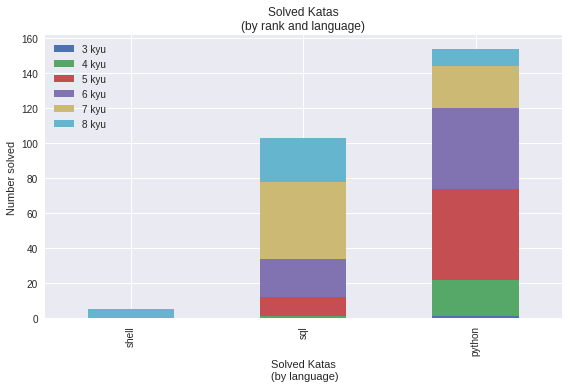

In [4]:
plt.style.use('seaborn')
pd_lang = df_lang.toPandas()
pd_lang.set_index('prog_language', inplace=True)
pd_lang.plot(use_index=True, xlabel='Solved Katas\n (by language)', ylabel='Number solved', \
               kind='bar', stacked=True, title='Solved Katas\n(by rank and language)')

plt.tight_layout()
plt.show()

# Data is grouped and pivoted yet again, this time, to analyze kata solutions ranks by language.  

In [5]:
df_kata = df.groupBy('rank_name').pivot('prog_language').count()
df_kata.show()

+---------+------+-----+----+
|rank_name|python|shell| sql|
+---------+------+-----+----+
|    7 kyu|    24| null|  44|
|    6 kyu|    46| null|  22|
|    8 kyu|    10|    5|  25|
|    4 kyu|    21| null|   1|
|    3 kyu|     1| null|null|
|    5 kyu|    52| null|  11|
+---------+------+-----+----+



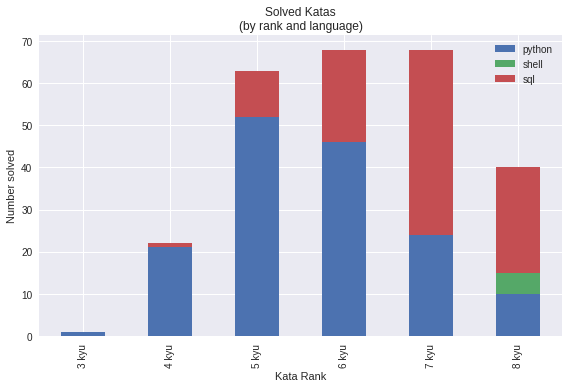

In [6]:
pd_kata = df_kata.toPandas()
pd_kata.set_index('rank_name', inplace=True)
pd_kata.sort_values('rank_name').plot(use_index=True, xlabel='Kata Rank', ylabel='Number solved', \
               kind='bar', stacked=True, title='Solved Katas\n(by rank and language)')

plt.tight_layout()
plt.show()

# The difficult part. Grouping data by a 1 week window partition. Pivoting rank_names and counting them up.

In [7]:
df_partitioned = df.groupBy(window("completed_at", "1 week")\
                            .alias("Duration (Week)")).pivot('rank_name')\
                            .agg(count('rank_name')).orderBy('Duration (Week)')

In [8]:
df_partitioned.show(10, False)

+------------------------------------------+-----+-----+-----+-----+-----+-----+
|Duration (Week)                           |3 kyu|4 kyu|5 kyu|6 kyu|7 kyu|8 kyu|
+------------------------------------------+-----+-----+-----+-----+-----+-----+
|{2021-07-01 00:00:00, 2021-07-08 00:00:00}|null |null |null |null |null |1    |
|{2021-07-08 00:00:00, 2021-07-15 00:00:00}|null |null |4    |2    |6    |2    |
|{2021-07-22 00:00:00, 2021-07-29 00:00:00}|null |1    |null |null |1    |null |
|{2021-07-29 00:00:00, 2021-08-05 00:00:00}|null |null |null |4    |1    |1    |
|{2021-08-05 00:00:00, 2021-08-12 00:00:00}|null |null |null |1    |1    |null |
|{2021-08-12 00:00:00, 2021-08-19 00:00:00}|null |1    |1    |null |5    |null |
|{2021-08-19 00:00:00, 2021-08-26 00:00:00}|null |null |null |9    |7    |null |
|{2021-08-26 00:00:00, 2021-09-02 00:00:00}|null |null |null |1    |null |null |
|{2021-09-02 00:00:00, 2021-09-09 00:00:00}|null |1    |null |1    |2    |2    |
|{2021-09-09 00:00:00, 2021-

In [9]:
df_pandas = df_partitioned.toPandas()
df_pandas[['start', 'end']] = (df_pandas['Duration (Week)'].tolist())
df_pandas.drop(columns=['Duration (Week)', 'end'], inplace=True)
df_pandas['start'] = df_pandas['start'].dt.date
df_pandas.set_index('start', inplace=True)

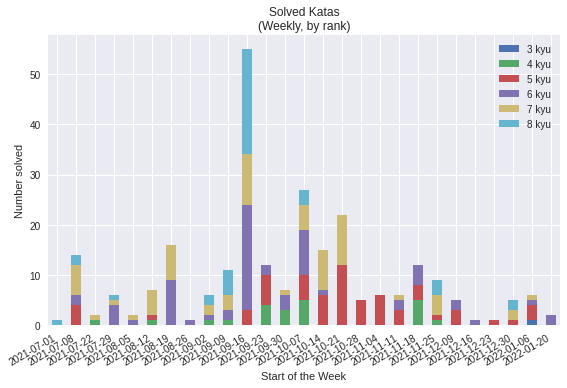

In [10]:
df_pandas.plot(use_index=True, xlabel='Start of the Week', ylabel='Number solved', \
               kind='bar', stacked=True, title='Solved Katas\n(Weekly, by rank)')
plt.gcf().autofmt_xdate()

plt.tight_layout()
plt.show()